# Genexpert data exploration and analysis

*Initialize...*

In [35]:
from IPython.display import display, HTML

import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib as mlp
import matplotlib.pyplot as plt
import geopandas as gp

%matplotlib inline
plt.style.use('ggplot')
mlp.rcParams["figure.facecolor"] = "white"

In [2]:
priority_deptos = [ 5, 12, 10, 9, 11, 18, 19 ]

## Read cohort data

In [3]:
datadf = pd.read_csv(\
"../../../../Outcome Measurement Data/TUBERCULOSIS/GTM - Tx cohort data 2012-2016.csv", index_col = 0)
#deptos = gp.read_file("../../../../Covariates and Other Data/GIS/GT-IGN-cartografia_basica-Departamentos.geojson")

In [17]:
import os
#sys.path.append('../../../core/')
os.chdir("../../../core")
import GT_helper_functions as hf
import GT_load_data as data

base_dir = "../../Outcome Measurement Data/"

FileNotFoundError: [WinError 2] El sistema no puede encontrar el archivo especificado: '../../../core'

In [7]:
temp = datadf[#(datadf.row_name_.isin(["FALLECIDOS"])) & 
              (datadf.col_name.isin(["TOTAL"])) & 
       (datadf.table.isin(["Nuevos Pulmonares BK+", "Nuevos Pulmonares BK-", "Nuevos Pediatricos", 
                          "Nuevos Extrapulmonares", "Nuevos TB/VIH", "Retratamiento"
                          ])) &
       (datadf.deptocode!=0)].\
    groupby(["year", "row_name"]).value.sum().unstack(1)
temp["total"] = temp.sum(axis="columns")
temp

row_name,ABANDONO/PERDIDA_SEGM,CURADOS,FALLECIDOS,FRACASO_TERAPEUTICO,TRANSFERIDOS,TRATAMIENTOS COMPLETOS,total
year,,,,,,,
2012,194.0,1926.0,227.0,49.0,30.0,1221.0,3647.0
2013,252.0,1859.0,244.0,48.0,23.0,1046.0,3472.0
2014,257.0,1829.0,198.0,50.0,3.0,925.0,3262.0
2015,258.0,1911.0,211.0,46.0,8.0,1015.0,3449.0
2016,215.0,1899.0,196.0,42.0,12.0,922.0,3286.0


In [34]:
temp = datadf[(datadf.col_name.isin(["TOTAL"])) & 
       (datadf.table.isin(["Nuevos Pulmonares Genexpert"
                          ])) &
       (datadf.deptocode!=0)].\
    groupby(["year", "row_name"]).value.sum().unstack(1)

In [34]:
temp["total"] = temp.sum(axis="columns")
temp

row_name,ABANDONO/PERDIDA_SEGM,CURADOS,FALLECIDOS,FRACASO_TERAPEUTICO,TRANSFERIDOS,TRATAMIENTOS COMPLETOS,total
year,,,,,,,
2016,15.0,25.0,11.0,1.0,0.0,137.0,189.0


## Read notifications data 

In [5]:
tbnots = pd.read_csv(base_dir + "TUBERCULOSIS/GTM - TB notifications 2012-2017.csv", 
                     encoding="latin-1", index_col = 0)

C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (4,8,9,10,12,21,22,23,24,25,26,27,28,29,30,31,32,33,35,36,38,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,63,64,65,66,67,69,70,71,79,80,81,82) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
tbnots.head()

,NOMBRES,DIRECCION,MUNICIPIO,DEPARTAMENTO,SERVICIODESALUD,SEXO,EDAD,RANGOEDAD,PESOLBS,PESOKG,...,CULTIVO_RESULTADO,CULTIVO_FECHA,FECHA,OBSERVACION,RESISTENCIA,FECHARESULTADOPDS,NotificationDate,YearMonth_,DEPTO_CORRECTED,COD_DEPT
1,NaN,NaN,TUCURU,ALTA VERAPAZ,"CS, TUCURU",m,17.0,015 - 019,123,55.90909091,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ALTA VERAPAZ,16
2,NaN,NaN,TUCURU,ALTA VERAPAZ,"CS, TUCURU",m,49.0,045 - 049,125,56.81818182,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ALTA VERAPAZ,16
3,NaN,NaN,TUCURU,ALTA VERAPAZ,"CS, TUCURU",m,25.0,025 - 029,97,44.09090909,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ALTA VERAPAZ,16
4,NaN,NaN,TUCURU,ALTA VERAPAZ,"CS, TUCURU",f,46.0,045 - 049,88,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ALTA VERAPAZ,16
5,NaN,NaN,TELEMAN,ALTA VERAPAZ,"CS, TELEMAN",m,47.0,045 - 049,ND,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ALTA VERAPAZ,16


## Genexpert

In [6]:
#tbnots.METODODX.value_counts(dropna=False)
tbnots["Genexpert"] =  tbnots.METODODX.map(lambda x: "xpert" in str.lower(x) if not pd.isna(x) else False)

In [7]:
tbnots["Year"] = np.floor(tbnots.YearMonth/100)

In [59]:
gxpertMapData = tbnots[(tbnots.CONDICIONINGRESO == "nuevo") & 
                       (tbnots.Year>2014)].groupby(["Year", "Genexpert", "COD_DEPT"])\
                            .apply(len).unstack(1, fill_value=0)

In [60]:
gxpertMapData = gxpertMapData.reset_index().rename(columns={ "COD_DEPT": "deptocode"}).assign(Total = lambda x: x[False] + x[True])\
                        .assign(Percentage = lambda x: x[True]/x["Total"]*100)

In [68]:
mlp.rcParams['figure.figsize'] = [8, 8]

def deptosMap2Way(x, y = None, mapdata = None, xlabel="", ylabel="", xmax = None, grayZeroX = True):
    if xmax is None:
        xmax = temp[x].max()
    mapdata = mapdata.assign(deptocode=lambda x: (x.deptocode * 100).astype(int).astype(str)\
                                                 .map(lambda y: y if y != "100" else "101"))
    temp = data.deptosGTshp.merge(mapdata[["deptocode", x]], 
                         left_on="CODIGO", right_on = "deptocode", how="left" )
    
    nans = temp[temp[x].isna() | (temp[x]==0) | (np.isinf(temp[x]))]
    if len(nans) > 0:
        nans.plot(color="grey", ax= ax) 

    goodvals = temp[(temp[x].isna()==False)]
    if len(goodvals) > 0:
        goodvals.plot(x, ax=ax, vmin = 0, vmax = xmax,
                                    legend=False, edgecolor="black", cmap = "Blues")
    l1 = ax.get_legend()
    for i, depto in data.deptosGTshp.iterrows():
        plt.text(depto.geometry.centroid.x, (depto.geometry.bounds[3]+1.5*depto.geometry.centroid.y)/2.5, 
                 hf.abbreviate(depto.DEPARTAMEN), color="black",
                 horizontalalignment='center', alpha=0.8, fontsize=9)

    if y is not None:
        temp2 = data.deptosGTshp.merge(mapdata[["deptocode", y]][mapdata[y]>0], 
                             left_on="CODIGO", right_on = "deptocode", how="left" )\
            .assign(_x = lambda row: row.geometry.centroid.x)\
            .assign(_y = lambda row: row.geometry.centroid.y)
        plt.scatter(temp2._x, temp2._y, temp2[y], c = "red", alpha=0.6, linewidths=1.5, edgecolors="black", 
                label = ylabel + " ( " + str(temp2[y].min()) + " to " + str(temp2[y].max()) + " )")

    cmap = plt.get_cmap('Blues')
    norm = mlp.colors.Normalize(vmin=0,vmax=xmax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, shrink = 0.5, ticks=np.linspace(0, xmax, 10))
    cbar.set_ticklabels([int(np.round(x)) for x in np.linspace(0, xmax, 10)])
    cbar.set_label(xlabel)
    plt.legend(bbox_to_anchor=(1,0))
    plt.axis("off")


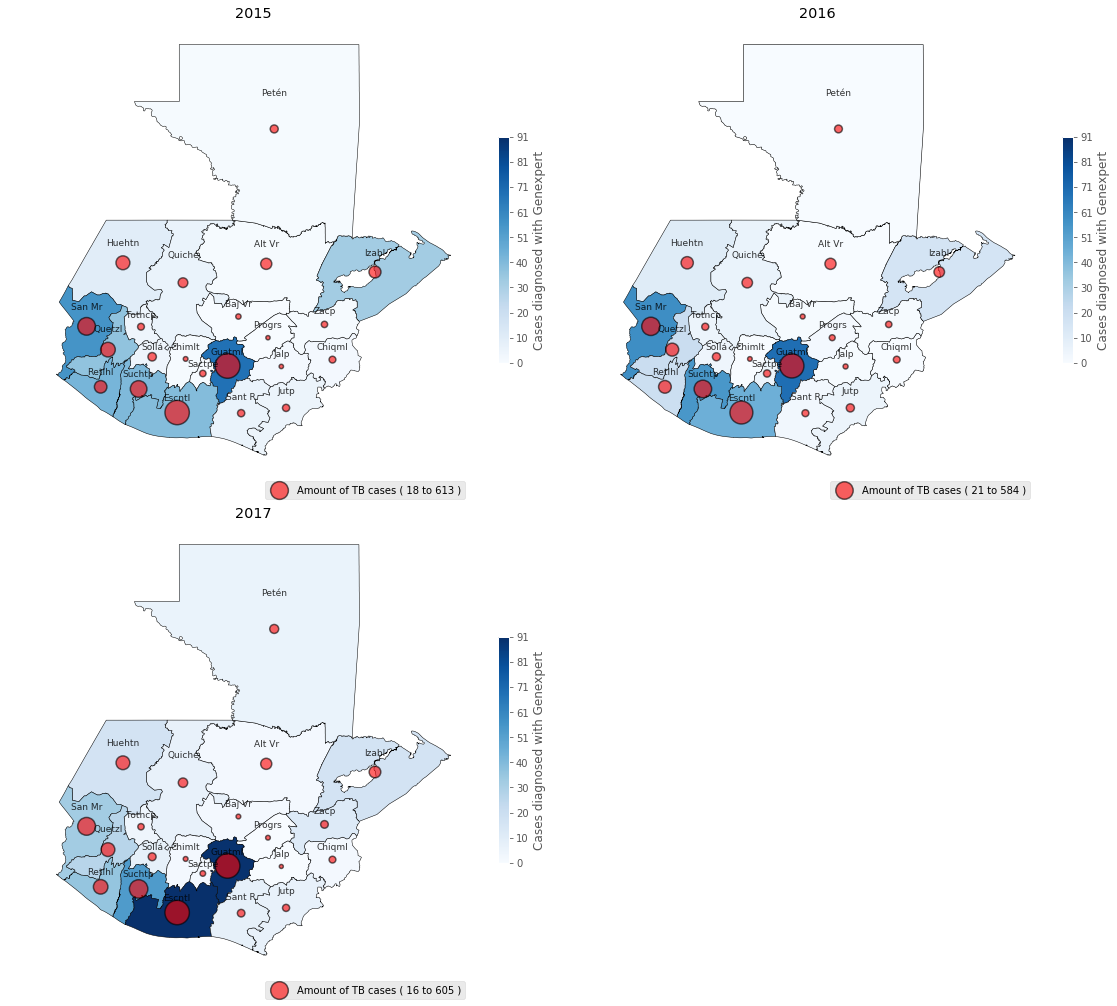

In [69]:
mlp.rcParams["figure.figsize"] = (16, 14)
xmax = gxpertMapData[True].max()
ax = plt.subplot(2,2,1)
deptosMap2Way(True, "Total", gxpertMapData[gxpertMapData.Year == 2015], "Cases diagnosed with Genexpert", "Amount of TB cases",
             xmax = xmax)
ax.set_title("2015")
ax = plt.subplot(2,2,2)
deptosMap2Way(True, "Total", gxpertMapData[gxpertMapData.Year == 2016], "Cases diagnosed with Genexpert", "Amount of TB cases",
             xmax = xmax)
ax.set_title("2016")
ax = plt.subplot(2,2,3)
deptosMap2Way(True, "Total", gxpertMapData[gxpertMapData.Year == 2017], "Cases diagnosed with Genexpert", "Amount of TB cases",
             xmax = xmax)
ax.set_title("2017")
plt.tight_layout(pad=0.8)

In [70]:
tbnots[(tbnots.CONDICIONINGRESO == "nuevo") ].groupby(["Year", "Genexpert"]).apply(len).unstack(1).fillna(0)

Genexpert,False,True
Year,,
2012.0,3192.0,0.0
2013.0,3100.0,0.0
2014.0,2964.0,0.0
2015.0,2854.0,361.0
2016.0,2777.0,328.0
2017.0,2872.0,426.0


In [73]:
tbnots[(tbnots.CONDICIONINGRESO == "nuevo") ].groupby(["Year", "Genexpert", "SEXO", "EDAD"])\
    .Genexpert.count().unstack(1).unstack(1).fillna(0).to_excel("temp.xlsx")